# Extract features CIFAR10

In [1]:
import numpy as np

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage import filters, color
from PIL import Image

In [2]:
# imports the cifar files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# returns a image rgb array, label and label's name of the image with index im_idx
def cifar10_img_info(data, meta, im_idx=0):
    im = data[b'data'][im_idx, :]

    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    label = data[b'labels'][im_idx]
    category = meta[b'label_names'][data[b'labels'][im_idx]]

    return img, label, category

In [4]:
# returns a image rgb array
def img_reshape(im):
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    
    return img

In [5]:
# returns X and y of the dataset, X.shape = (nº of samples x features) and y.shape = (nº of samples)
def batch_to_xy(batch):
    X = batch[b"data"]
    y = batch[b"labels"]
    y = np.array(y)
    y.reshape(y.shape[0])
    return X, y

In [6]:
def sobel_kernel(img):
    sobel_img = filters.sobel(img)
    return sobel_img

In [7]:
def to_gray(img):
    #return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    return color.rgb2gray(img)

In [8]:
def to_gray1(data):
    gray_data = np.zeros((data.shape[0],1024))
    for i in range(data.shape[0]):
        img_aux = img_reshape(data[i,:])
        gray_img_aux = color.rgb2gray(img_aux)
        gray_data[i,:] = gray_img_aux.reshape(1,1024)
    return gray_data

## The dataset

In [9]:
# batch with 10000 examples
batch1 = unpickle("cifar-10-batches-py/data_batch_1")
# meta has the labels' names
meta = unpickle("cifar-10-batches-py/batches.meta")

Showing a example from the batch

In [10]:
# change this to see another example
img_idx = 8

In [11]:
img_ex, label_ex, category_ex = cifar10_img_info(batch1, meta, img_idx)

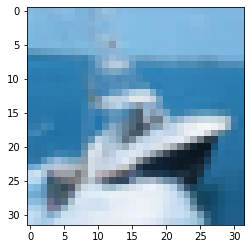

In [12]:
plt.imshow(img_ex)

In [13]:
print("Label: "+str(label_ex)+"\nCategory: "+str(category_ex))

Label: 8
Category: b'ship'


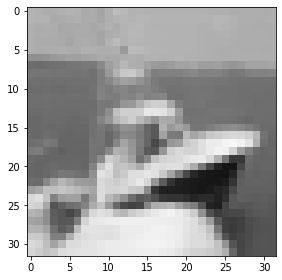

In [14]:
imshow(to_gray(img_ex))

In [15]:
to_gray(img_ex).shape

(32, 32)

Preparing the dataset

In [16]:
X, y = batch_to_xy(batch1)

In [17]:
X.shape

(10000, 3072)

In [18]:
y.shape

(10000,)

In [19]:
X_gray = to_gray1(X)

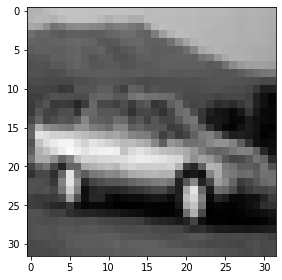

In [48]:
imshow(X_gray[4,:].reshape(32,32))

In [49]:
Xsobel = sobel_kernel(X_gray[4,:])

In [50]:
Xsobel.shape

(1024,)

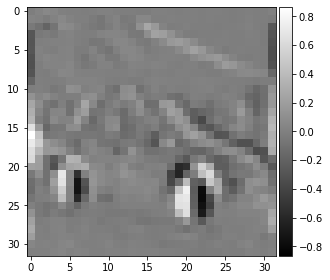

In [51]:
imshow(Xsobel.reshape(32,32),cmap='gray')

In [44]:
Xsobel

array([-0.14997294, -0.27164667, -0.13145922, ...,  0.01541843,
        0.00141373, -0.00224   ])

In [211]:
# initial training data size that will be given to the learner
n_initial = 200

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
# deleting the initial examples from the pool
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

In [213]:
print(X)

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]


In [214]:
y

array([6, 9, 9, ..., 1, 1, 5])

## Initializing the learner

In [215]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

From the examples: "We also set how many queries we want to make. The more the better! (Usually :) )"

In [216]:
n_queries = 20

## The active learning loop

In [217]:
accuracy_scores = [learner.score(X_test, y_test)]

for i in range(n_queries):
  query_index, query_instance = learner.query(X_pool)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_test, y_test)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=i + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  accuracy_scores.append(model_accuracy)

Accuracy after query 1: 0.2592
Accuracy after query 2: 0.2388
Accuracy after query 3: 0.2448
Accuracy after query 4: 0.2464
Accuracy after query 5: 0.2548
Accuracy after query 6: 0.2540
Accuracy after query 7: 0.2556
Accuracy after query 8: 0.2588
Accuracy after query 9: 0.2640
Accuracy after query 10: 0.2592
Accuracy after query 11: 0.2376
Accuracy after query 12: 0.2516
Accuracy after query 13: 0.2580
Accuracy after query 14: 0.2548
Accuracy after query 15: 0.2488
Accuracy after query 16: 0.2540
Accuracy after query 17: 0.2468
Accuracy after query 18: 0.2496
Accuracy after query 19: 0.2540
Accuracy after query 20: 0.2444


We can visualize the accuracy during the training.

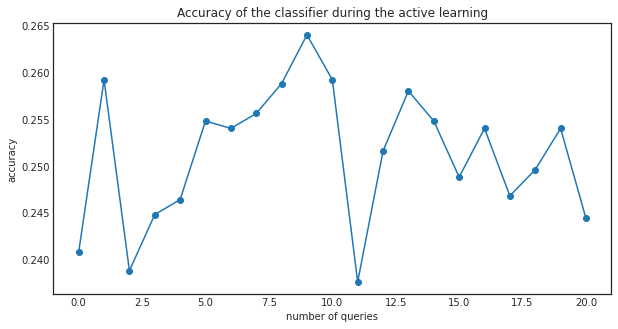

In [218]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_queries+1), accuracy_scores)
    plt.scatter(range(n_queries+1), accuracy_scores)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()